# 0. import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, VotingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from imblearn.over_sampling import SMOTE
import joblib
%matplotlib inline

# 1. Get the data

In [2]:
#import csv file
cc_data_full_data = pd.read_csv('dataset/application_record.csv')
credit_status = pd.read_csv('dataset/credit_record.csv')

In [3]:
# creating the target variable
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
warnings.simplefilter(action='always', category=SettingWithCopyWarning)

In [4]:
# change the account in months
cc_data_full_data['Account age'] = np.abs(cc_data_full_data['Account age']).astype('int32')

In [5]:
# rename the columns to a more readable format
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age in days',
    'DAYS_EMPLOYED': 'Employment length in days',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age in months'
})

In [6]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [7]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [8]:
cc_train_original.shape

(29165, 20)

In [9]:
cc_test_original.shape

(7292, 20)

In [10]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

# Explore the Data

In [11]:
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment type,Education level,Marital status,Dwelling,Age in days,Employment length in days,Has a mobile phone,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age in months,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,15,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,14,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,29,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,4,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,26,0


In [12]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         36457 non-null  int64  
 1   Gender                     36457 non-null  object 
 2   Has a car                  36457 non-null  object 
 3   Has a property             36457 non-null  object 
 4   Children count             36457 non-null  int64  
 5   Income                     36457 non-null  float64
 6   Employment type            36457 non-null  object 
 7   Education level            36457 non-null  object 
 8   Marital status             36457 non-null  object 
 9   Dwelling                   36457 non-null  object 
 10  Age in days                36457 non-null  int64  
 11  Employment length in days  36457 non-null  int64  
 12  Has a mobile phone         36457 non-null  int64  
 13  Has a work phone           36457 non-null  int

In [13]:
cc_data_full_data.describe()

,ID,Children count,Income,Age in days,Employment length in days,Has a mobile phone,Has a work phone,Has a phone,Has an email,Family member count,Account age in months
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,26.164193
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,16.501854
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,12.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,24.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,39.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,60.000000


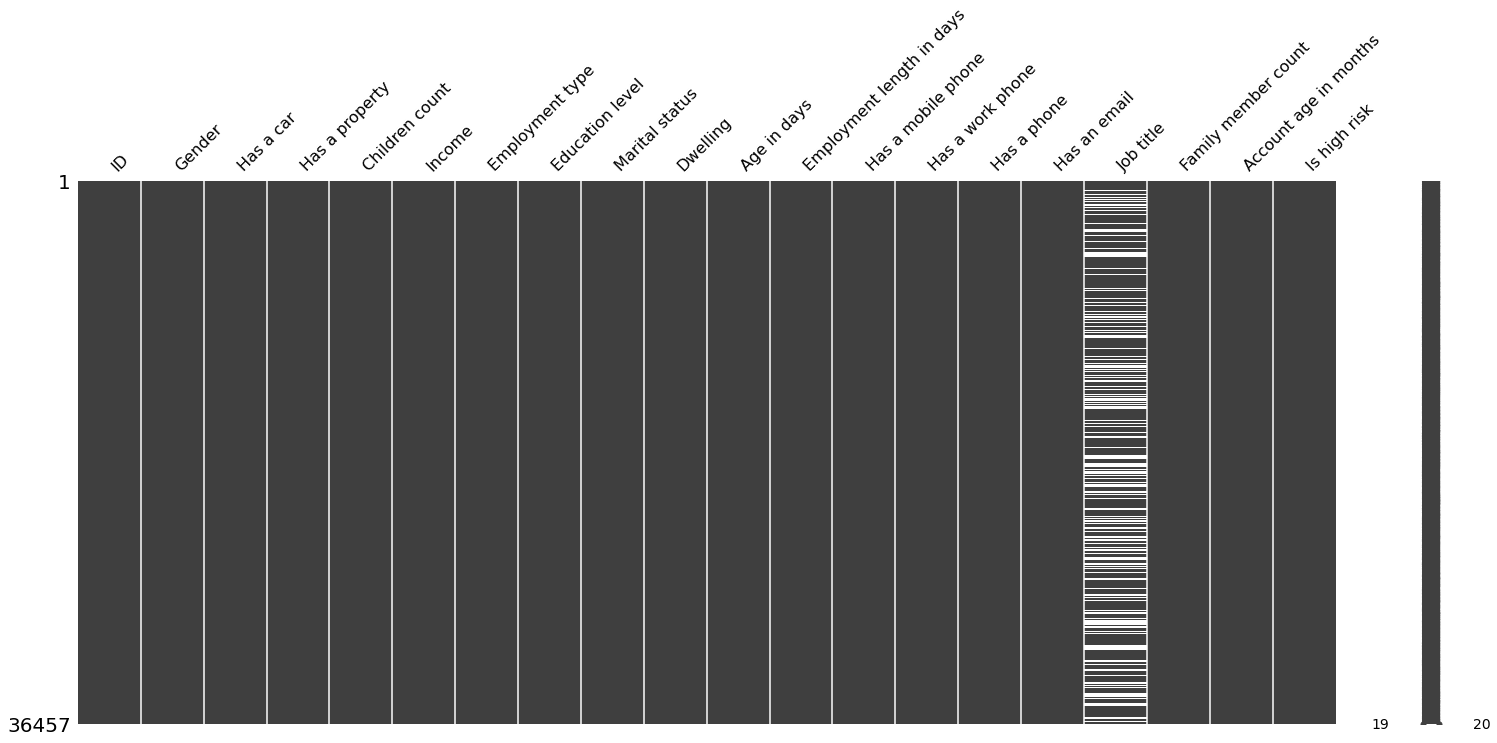

In [14]:
msno.matrix(cc_data_full_data)
plt.show()

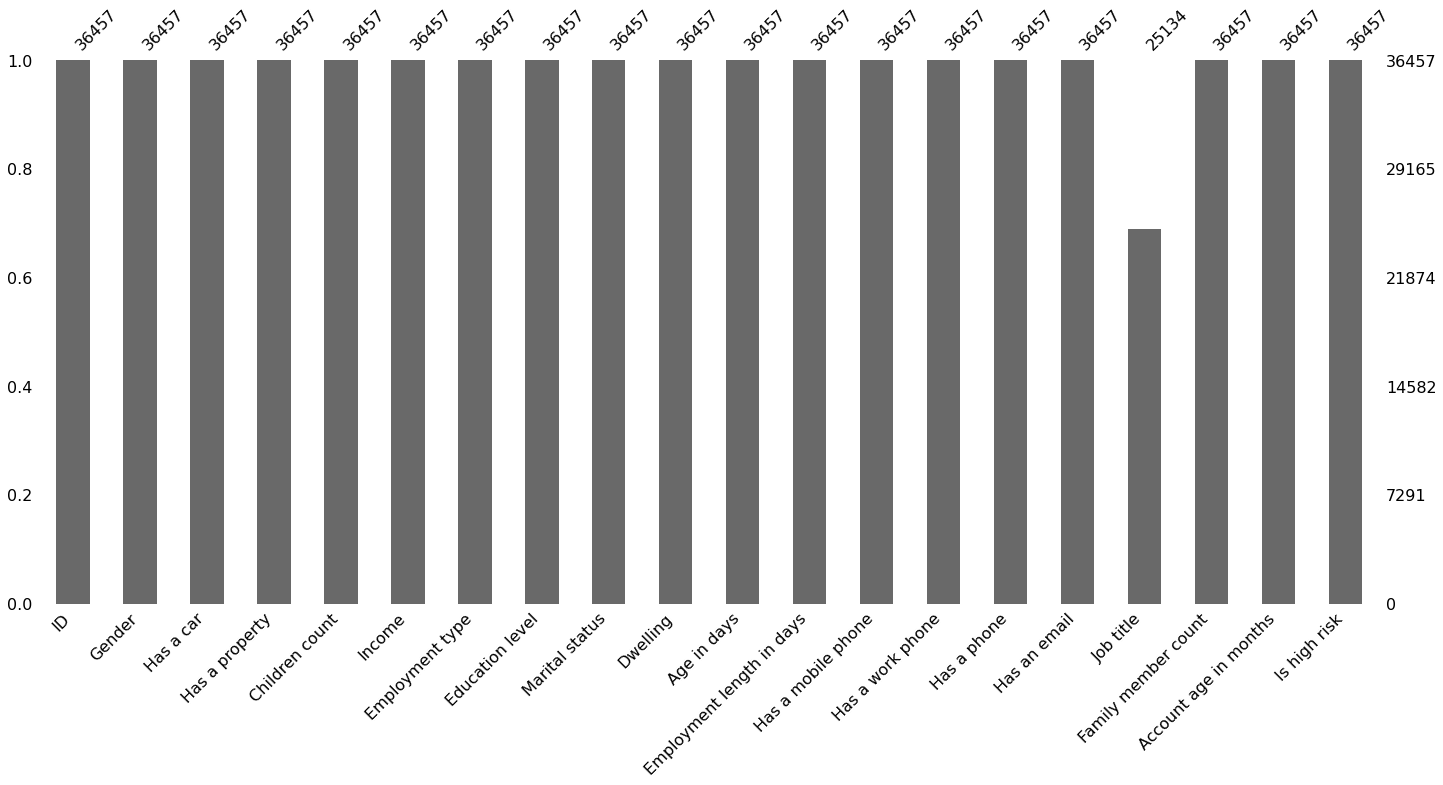

In [15]:
msno.bar(cc_data_full_data)
plt.show()

In [16]:
#Function that will return the value count and frequency of each observation within a column
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [99]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    match feature:
        case 'Age in days':
            # change the feature to be express in positive numbers days
            print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case 'Employment length in days':
            # select only the rows where the rows are negative to ignore whose who have retired or unemployed
            employment_len_no_ret = cc_train_copy['Employment length in days'][cc_train_copy['Employment length in days'] < 0]
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
            print('*'*50)
            print('Object type:{}'.format(employment_len_no_ret.dtype))
        case 'Account age in months':
            # change the account age to a positive number of months
            print('Description:\n{}'.format((np.abs(df[feature])).describe()))
            print('*'*50)
            print('Object type:{}'.format(df[feature].dtype))
        case _:
            print('Description:\n{}'.format(df[feature].describe()))
            print('*'*50)
            print('Object type:\n{}'.format(df[feature].dtype))
            print('*'*50)
            value_cnt = value_cnt_norm_cal(df,feature)
            print('Value count:\n{}'.format(value_cnt))


In [18]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    ratio_size = value_cnt_norm_cal(df, feature)
    ratio_size_len = len(ratio_size.index)
    ratio_list = []
    for i in range(ratio_size_len):
        ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
    fig, ax = plt.subplots(figsize=(10,10))
    # %1.2f%% display decimals in the pie chart with 2 decimal places
    plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90)
    plt.title('Pie chart of {}'.format(feature))
    plt.legend(loc='best')
    plt.axis('equal')
    return plt.show()

In [19]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    match feature:
        case 'Marital status' | 'Dwelling' | 'Job title' | 'Employment status' | 'Education level':
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(6,10))
            sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
            plt.xlabel('{}'.format(feature))
            plt.ylabel('Count')
            plt.title('{} count'.format(feature))
            return plt.show()

In [20]:
# function to create a box plot
def create_box_plot(df,feature):
    match feature:
        case 'Age in days':
            fig, ax = plt.subplots(figsize=(2,8))
            # change the feature to be express in positive numbers days
            sns.boxplot(y=np.abs(df[feature])/365.25)
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()
        case 'Children count':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,df[feature].max(),1))
            return plt.show()
        case 'Employment length in days':
            fig, ax = plt.subplots(figsize=(2,8))
            employment_len_no_ret = cc_train_copy['Employment length in days'][cc_train_copy['Employment length in days'] < 0]
            # employement length in days is a negative number so we need to change it to positive and change it to days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            sns.boxplot(y=employment_len_no_ret_yrs)
            plt.title('{} distribution(Boxplot)'.format(feature))
            plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(2,8))
            sns.boxplot(y=df[feature])
            plt.title('{} distribution(Boxplot)'.format(feature))
            return plt.show()

In [21]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    match feature:
        case 'Age in days':
            fig, ax = plt.subplots(figsize=(18,10))
            # change the feature to be express in positive numbers days
            sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Income':
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            # suppress scientific notation
            ax.get_xaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case 'Employment length in days':
            employment_len_no_ret = cc_train_copy['Employment length in days'][cc_train_copy['Employment length in days'] < 0]
            # change the feature to be express in positive numbers days
            employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()
        case _:
            fig, ax = plt.subplots(figsize=(18,10))
            sns.histplot(df[feature],bins=the_bins,kde=True)
            plt.title('{} distribution'.format(feature))
            return plt.show()

In [22]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    match feature:
        case 'Age in days':
            print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by age')
            return plt.show()
        case 'Income':
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            # suppress scientific notation
            ax.get_yaxis().set_major_formatter(
                matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()
        case 'Employment length in days':
            #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
            employment_no_ret = cc_train_copy['Employment length in days'][cc_train_copy['Employment length in days'] <0]
            employment_no_ret_idx = employment_no_ret.index
            employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
            employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length in days','Is high risk']]
            employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length in days'].mean()
            # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
            print(np.abs(employment_no_ret_is_high_risk)/365.25)
            # print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High vs low risk individuals grouped by {}'.format(feature))
            return plt.show()
        case _:
            print(np.abs(df.groupby('Is high risk')[feature].mean()))
            fig, ax = plt.subplots(figsize=(5,8))
            sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
            plt.xticks(ticks=[0,1],labels=['no','yes'])
            plt.title('High risk individuals grouped by {}'.format(feature))
            return plt.show()

In [23]:
# High risk vs low risk applicants compared on a bar plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [96]:
cc_train_copy.shape

(29165, 20)

## 1. Gender

In [24]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     29165
unique        2
top           F
freq      19549
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
F  19549      67.028973
M   9616      32.971027


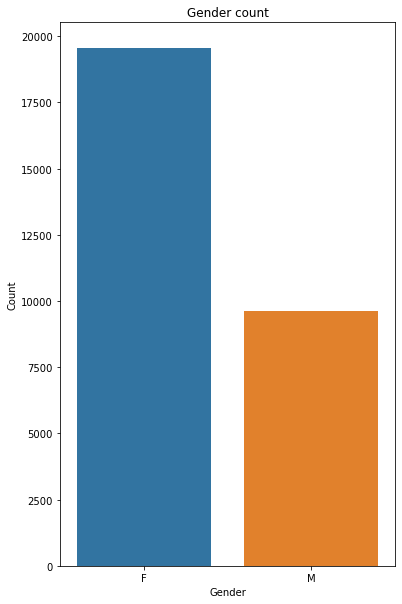

In [25]:
create_bar_plot(cc_train_copy,'Gender')

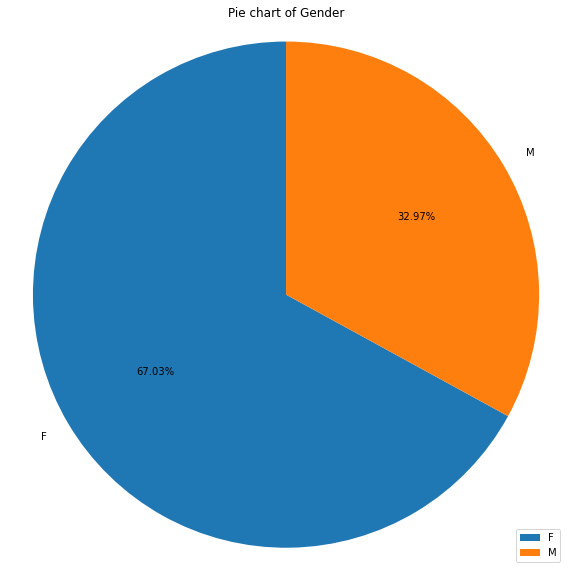

In [26]:
create_pie_plot(cc_train_copy,'Gender')

Interpretation:
- We have more female applicants than male (67% vs 32%)

## 2. Age

In [27]:
gen_info_feat(cc_train_copy,'Age in days')

Description:
count    29165.000000
mean        43.749425
std         11.507180
min         21.095140
25%         34.154689
50%         42.614648
75%         53.234771
max         68.862423
Name: Age in days, dtype: float64
**************************************************
Object type:int64


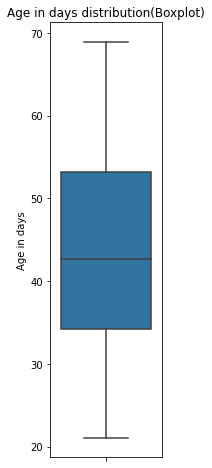

In [28]:
create_box_plot(cc_train_copy,'Age in days')

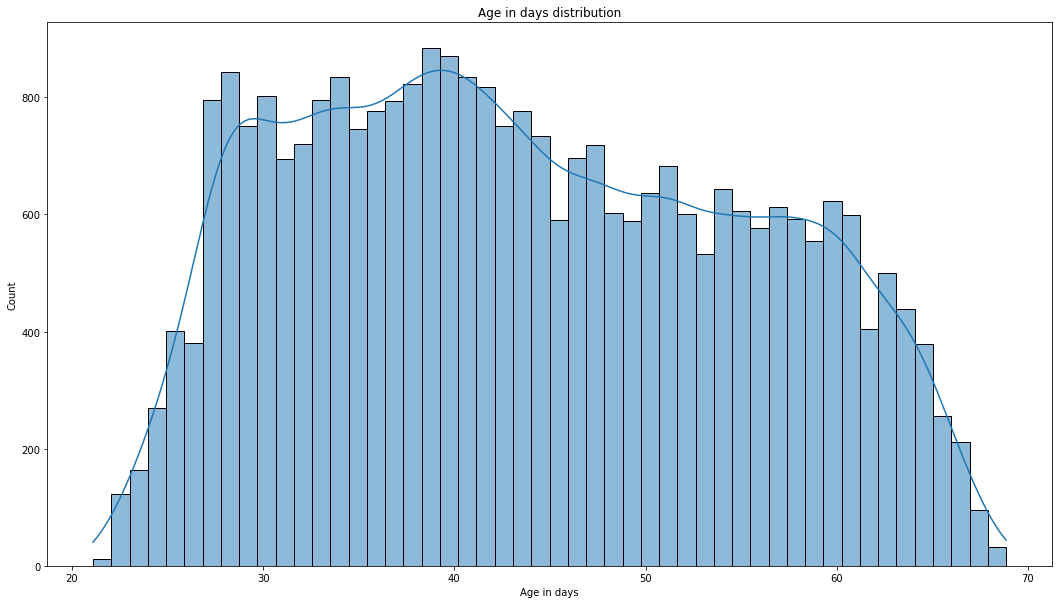

In [29]:
create_hist_plot(cc_train_copy,'Age in days')

Is high risk
0    43.753103
1    43.538148
Name: Age in days, dtype: float64


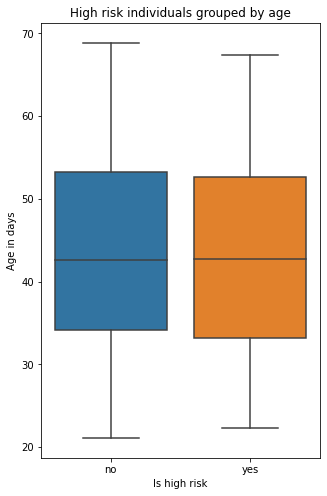

In [30]:
low_high_risk_box_plot(cc_train_copy,'Age in days')

Interpretation:
- The youngest applicant is 21 years old while the oldest is 68 years old. with the average of 43.7 and median of 42.6(outliers insensitive)
- Age feature is not normally distributed, it is slightly positively skew
- There is no difference between the average age of high and low risk applicants**

** This information might not be accurate because imbalance in the target variable

## 3. Marital status

In [31]:
gen_info_feat(cc_train_copy,'Marital status')

Description:
count       29165
unique          5
top       Married
freq        20044
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Married               20044      68.726213
Single / not married   3864      13.248757
Civil marriage         2312       7.927310
Separated              1712       5.870050
Widow                  1233       4.227670


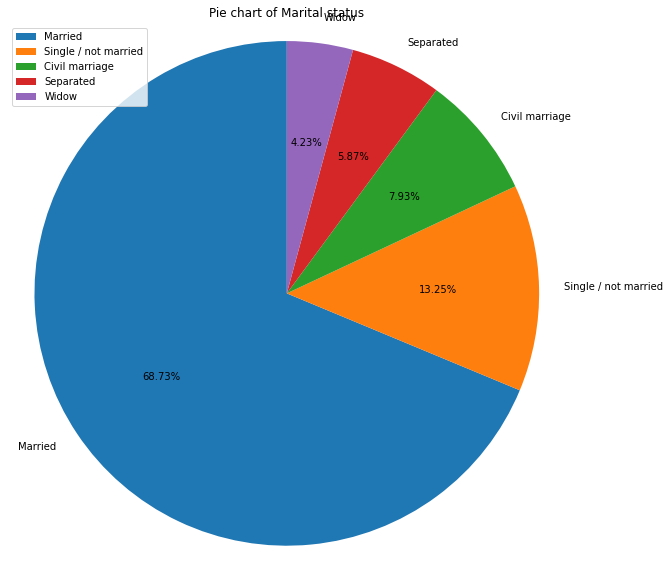

In [32]:
create_pie_plot(cc_train_copy,'Marital status')

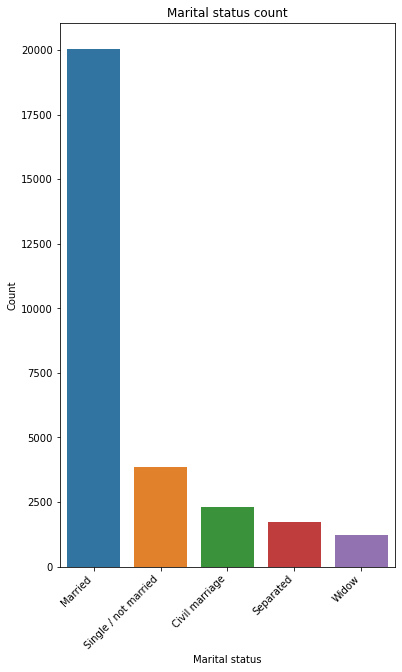

In [33]:
create_bar_plot(cc_train_copy,'Marital status')

{'Married': 320, 'Single / not married': 87, 'Civil marriage': 34, 'Widow': 34, 'Separated': 24}


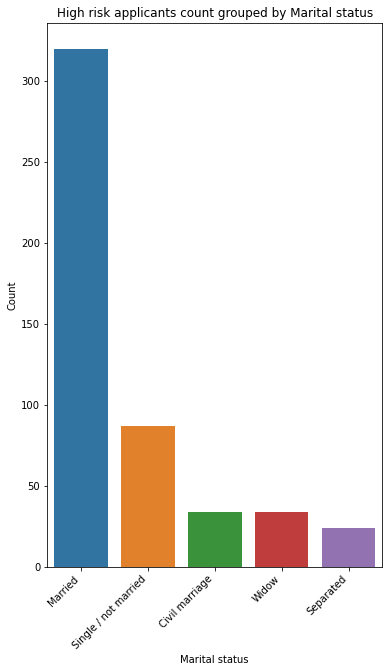

In [34]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

Interpretation:
- Most applicants are married
- Even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated.

## 4. Family member count

In [35]:
gen_info_feat(cc_train_copy,'Family member count')

Description:
count    29165.000000
mean         2.197531
std          0.912189
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
      Count  Frequency (%)
2.0   15552      53.324190
1.0    5613      19.245671
3.0    5121      17.558718
4.0    2503       8.582205
5.0     309       1.059489
6.0      48       0.164581
7.0      14       0.048003
9.0       2       0.006858
15.0      2       0.006858
20.0      1       0.003429


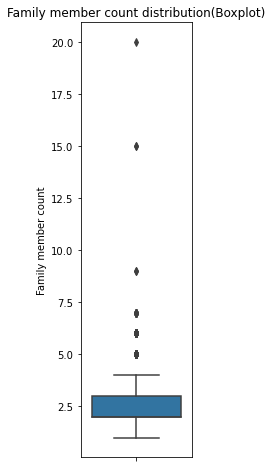

In [36]:
create_box_plot(cc_train_copy,'Family member count')

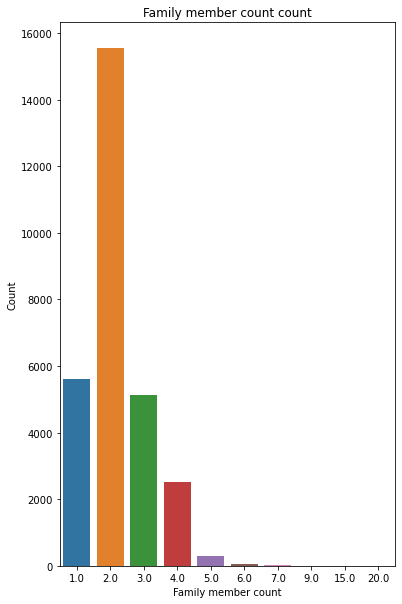

In [37]:
create_bar_plot(cc_train_copy,'Family member count')

Interpretation:
-   Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)
-   We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household


## 5. Children count

In [38]:
gen_info_feat(cc_train_copy,'Children count')

Description:
count    29165.000000
mean         0.430790
std          0.741882
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0   20143      69.065661
1    6003      20.582890
2    2624       8.997086
3     323       1.107492
4      52       0.178296
5      15       0.051432
7       2       0.006858
14      2       0.006858
19      1       0.003429


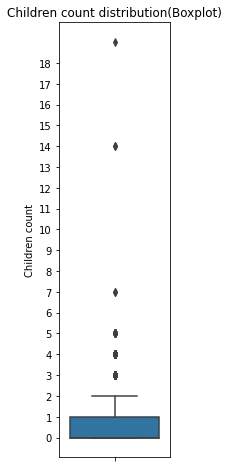

In [39]:
create_box_plot(cc_train_copy,'Children count')

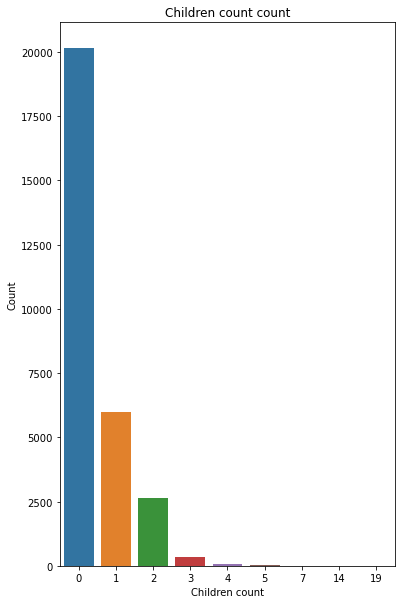

In [40]:
create_bar_plot(cc_train_copy,'Children count')

Interpretation:
-	As previously discussed most applicant don’t have a child
-	Also here we have 6 outliers, probably the same from the family member count

## 6. Dwelling type

In [41]:
gen_info_feat(cc_train_copy,'Dwelling')

Description:
count                 29165
unique                    6
top       House / apartment
freq                  26059
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
House / apartment    26059      89.350249
With parents          1406       4.820847
Municipal apartment    912       3.127036
Rented apartment       453       1.553232
Office apartment       208       0.713184
Co-op apartment        127       0.435453


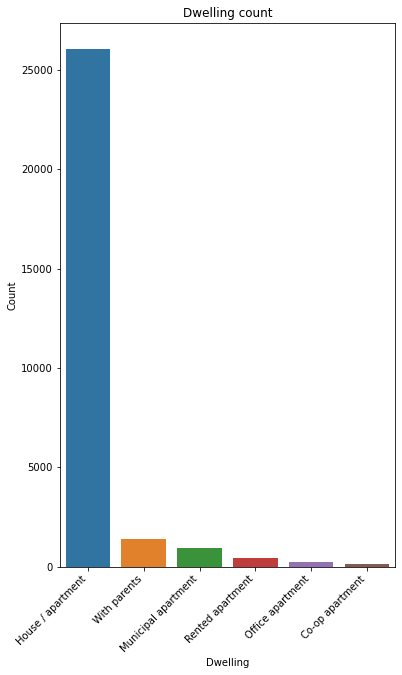

In [42]:
create_bar_plot(cc_train_copy,'Dwelling')

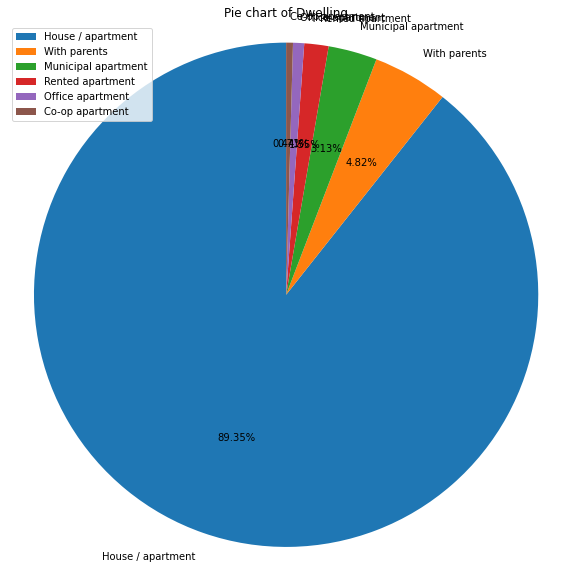

In [43]:
create_pie_plot(cc_train_copy,'Dwelling')

Interpretation:
- Almost every applicants live in house or apartment

## 7. Income

In [44]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy,'Income')

Description:
count     29165.00
mean     186890.39
std      101409.64
min       27000.00
25%      121500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
           Count  Frequency (%)
135000.00   3468          11.89
180000.00   2487           8.53
157500.00   2469           8.47
225000.00   2373           8.14
112500.00   2359           8.09
...          ...            ...
164250.00      1           0.00
42300.00       1           0.00
432000.00      1           0.00
145350.00      1           0.00
82350.00       1           0.00

[259 rows x 2 columns]


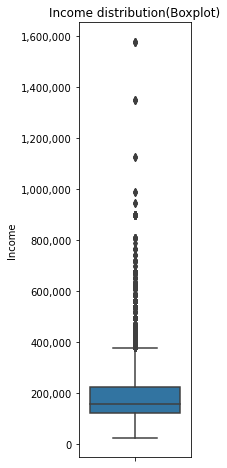

In [45]:
create_box_plot(cc_train_copy,'Income')

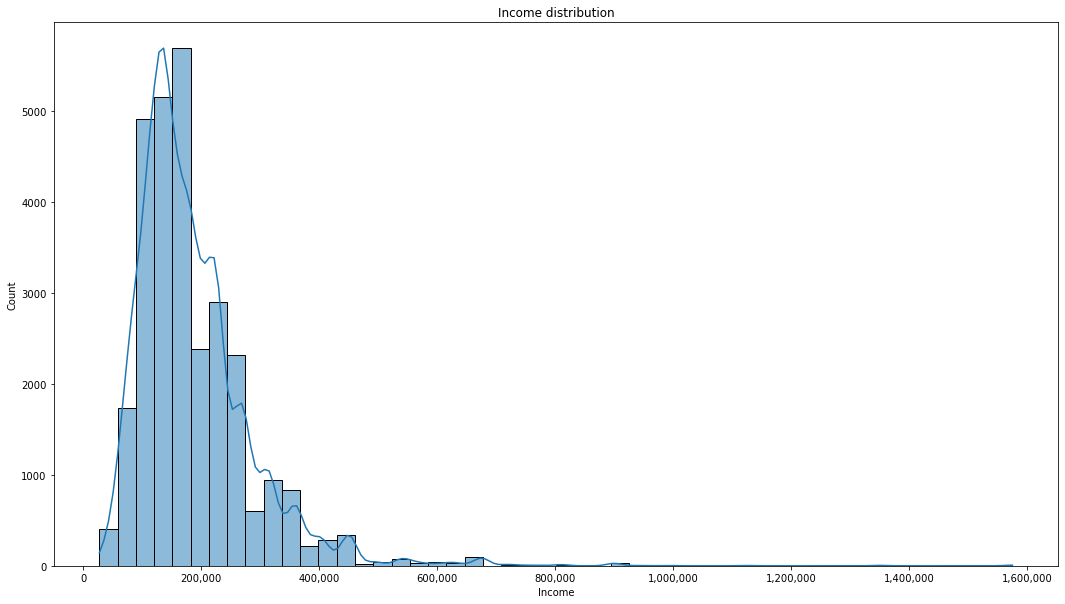

In [46]:
create_hist_plot(cc_train_copy,'Income')

Is high risk
0   186913.94
1   185537.26
Name: Income, dtype: float64


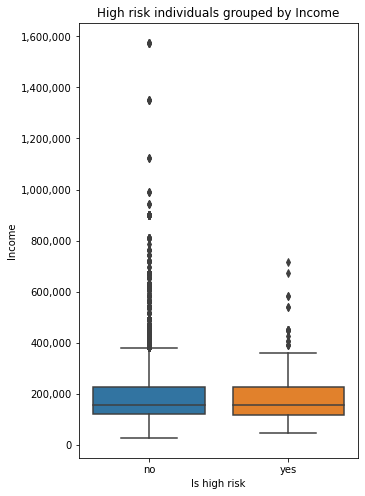

In [47]:
low_high_risk_box_plot(cc_train_copy,'Income')

Interpretation:
-	The average income is 186890 but this amount accounts for outliers. If we ignore the outlier most people make 157500
-	We have 3 applicants who makes more than 1000000
-	This feature is positively skewed
-	High risk and low risk applicants have roughly similar income**

** This information might not be accurate because imbalance in the target variable

## 8. Job title

In [48]:
gen_info_feat(cc_train_copy,'Job title')

Description:
count        20138
unique          18
top       Laborers
freq          5004
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Laborers                5004          24.85
Core staff              2866          14.23
Sales staff             2773          13.77
Managers                2422          12.03
Drivers                 1722           8.55
High skill tech staff   1133           5.63
Accountants              998           4.96
Medicine staff           956           4.75
Cooking staff            521           2.59
Security staff           464           2.30
Cleaning staff           425           2.11
Private service staff    287           1.43
Low-skill Laborers       138           0.69
Waiters/barmen staff     127           0.63
Secretaries              122           0.61
HR staff                  72           0.

In [49]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
job_title_nan_count

9027

In [50]:
rows_total_count = cc_train_copy.shape[0]

In [51]:
print('The percentage of missing rows is {:.2f} %'.format(job_title_nan_count * 100 / rows_total_count))

The percentage of missing rows is 30.95 %


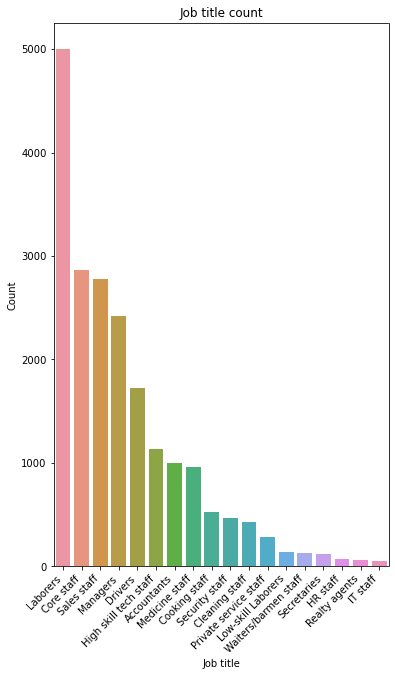

In [52]:
create_bar_plot(cc_train_copy,'Job title')

Interpretation:
-	The most prolific job title is laborers by far
-	We have 30.95% if missing data

## 9. Employment status

In [53]:
gen_info_feat(cc_train_copy,'Employment status')

Description:
count       29165
unique          5
top       Working
freq        15056
Name: Employment type, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working               15056          51.62
Commercial associate   6801          23.32
Pensioner              4920          16.87
State servant          2381           8.16
Student                   7           0.02


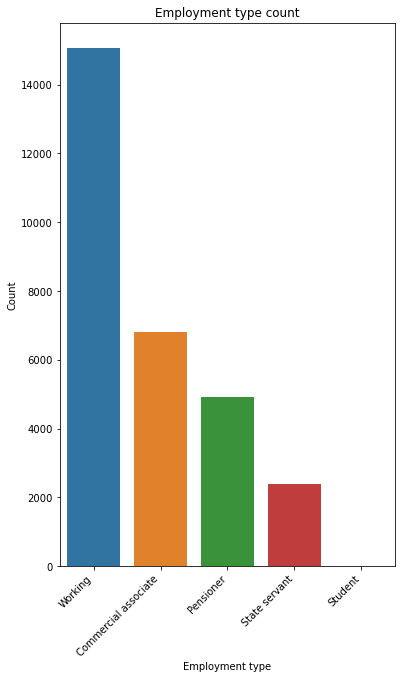

In [54]:
create_bar_plot(cc_train_copy,'Employment status')

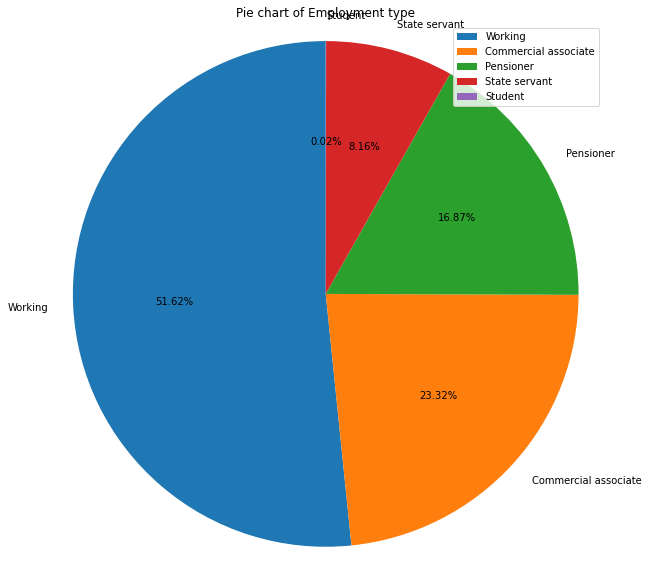

In [55]:
create_pie_plot(cc_train_copy,'Employment status')

Interpretation:
- Most applicants are employed

## 10. Education level

In [56]:
gen_info_feat(cc_train_copy,'Education level')

Description:
count                             29165
unique                                5
top       Secondary / secondary special
freq                              19803
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Secondary / secondary special  19803          67.90
Higher education                7910          27.12
Incomplete higher               1129           3.87
Lower secondary                  298           1.02
Academic degree                   25           0.09


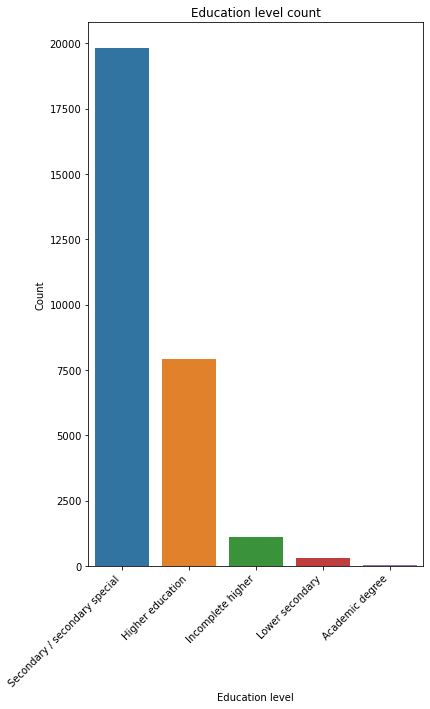

In [57]:
create_bar_plot(cc_train_copy,'Education level')

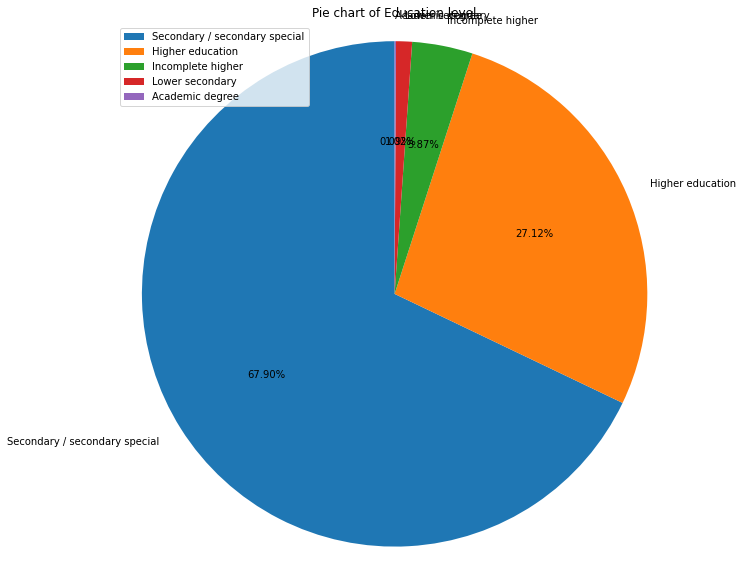

In [58]:
create_pie_plot(cc_train_copy,'Education level')

Interpretation:
-	The majority of applicants have completed their secondary degree, ¼ completed their higher education

## 11. Employment length in days

In [59]:
gen_info_feat(cc_train_copy,'Employment length in days')

Description:
count   24257.00
mean        7.26
std         6.46
min         0.05
25%         2.68
50%         5.45
75%         9.60
max        43.02
Name: Employment length in days, dtype: float64
**************************************************
Object type:int64


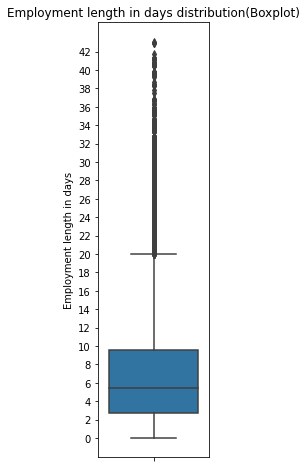

In [60]:
create_box_plot(cc_train_copy,'Employment length in days')

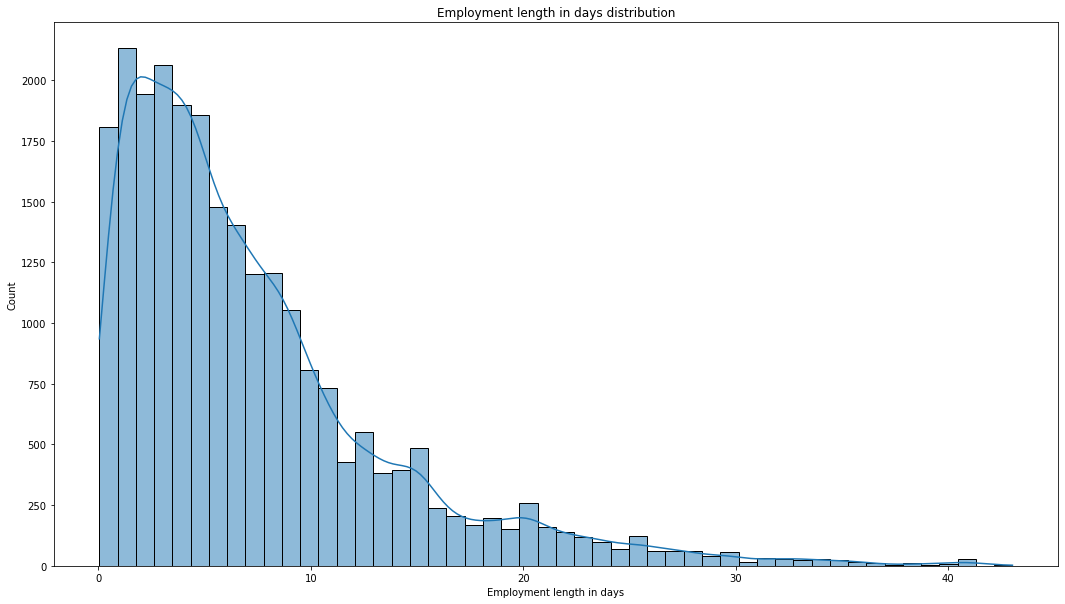

In [61]:
create_hist_plot(cc_train_copy,'Employment length in days')

Is high risk
0   7.29
1   5.75
Name: Employment length in days, dtype: float64


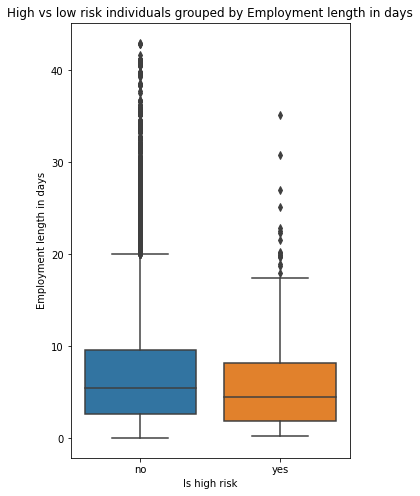

In [62]:
# distribution of employment length for high vs low risk applicants
low_high_risk_box_plot(cc_train_copy,'Employment length in days')

Interpretation:
-	Most of applicant have been working for 5 years
-	We have quite a number of outliers who have been working for more than 20 years+
-	The employment length is positively skewed
-	Those who are high risk have a low employment length of 5 versus 7 years for the low risk**


** This information might not be accurate because imbalance in the target variable

## 12. Has a car

In [64]:
gen_info_feat(cc_train_copy,'Has a car')

Description:
count     29165
unique        2
top           N
freq      18128
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N  18128          62.16
Y  11037          37.84


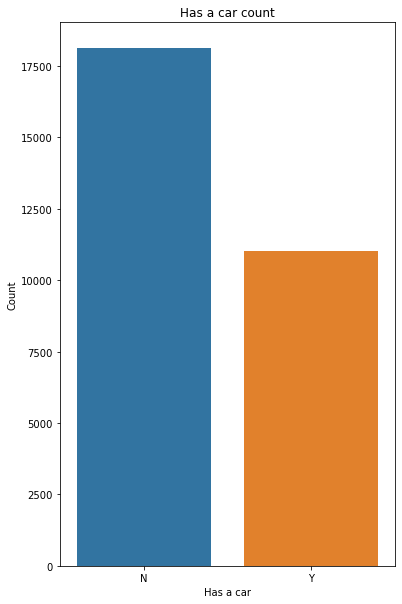

In [65]:
create_bar_plot(cc_train_copy,'Has a car')

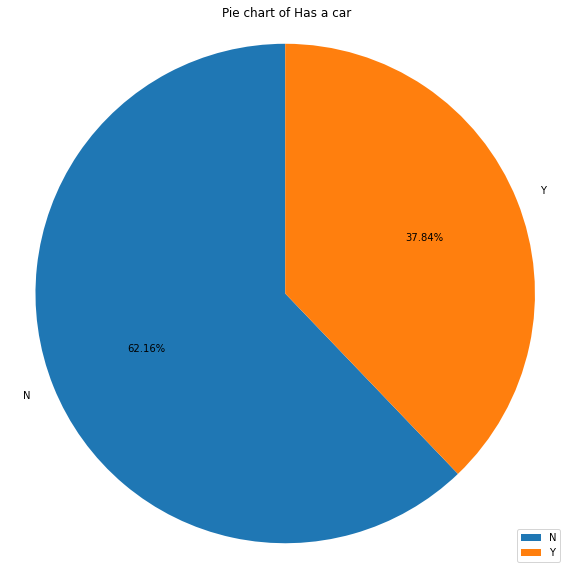

In [66]:
create_pie_plot(cc_train_copy,'Has a car')

Interpretation:
- Most applicant don’t own a car

## 13. Has a property

In [67]:
gen_info_feat(cc_train_copy,'Has a property')

Description:
count     29165
unique        2
top           Y
freq      19557
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y  19557          67.06
N   9608          32.94


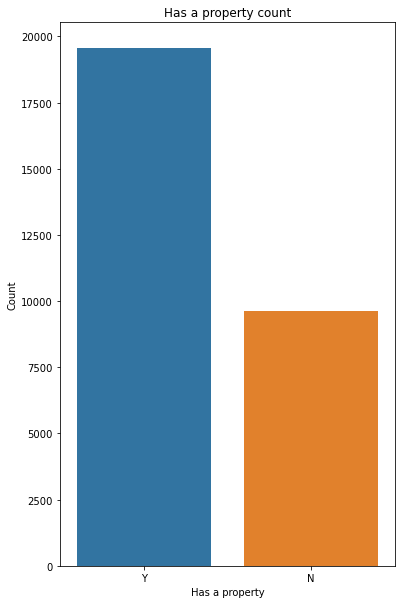

In [68]:
create_bar_plot(cc_train_copy,'Has a property')

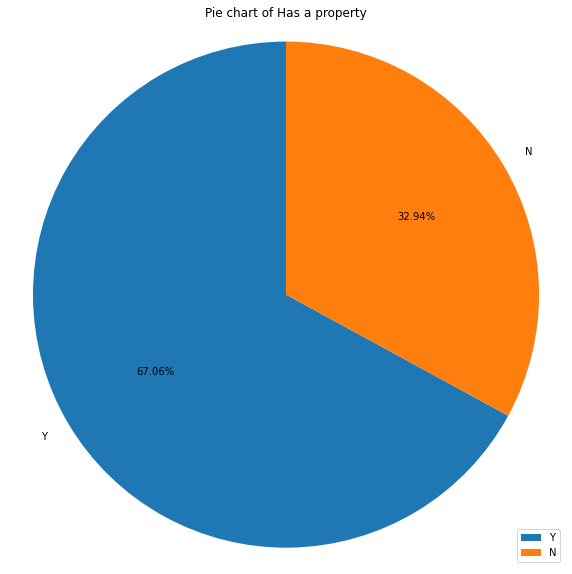

In [69]:
create_pie_plot(cc_train_copy,'Has a property')

Interpretation:
- Most applicants own a property

## 14. Has a work phone

In [70]:
# Note: Here 0 is no and 1 is yes

In [71]:
gen_info_feat(cc_train_copy,'Has a work phone')

Description:
count   29165.00
mean        0.22
std         0.42
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  22623          77.57
1   6542          22.43


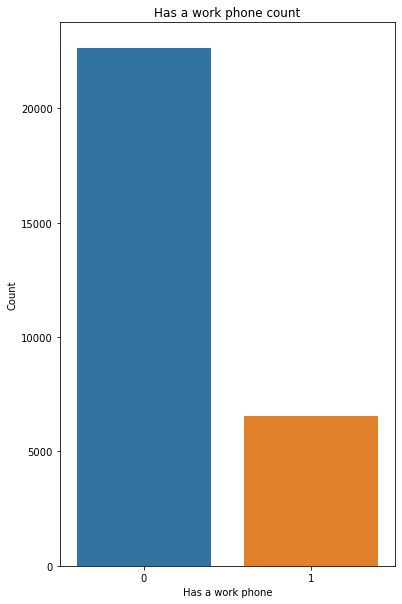

In [72]:
create_bar_plot(cc_train_copy,'Has a work phone')

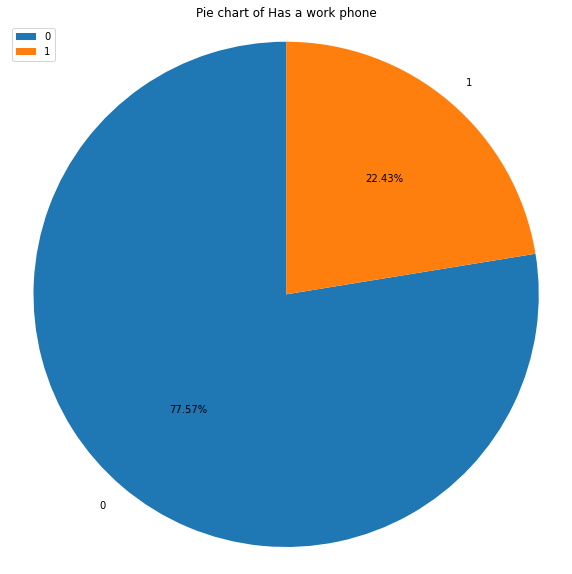

In [73]:
create_pie_plot(cc_train_copy,'Has a work phone')

Interpretation:
- More than ¾ of applicants don’t have a work phone

## 15. Has a mobile phone

In [75]:
# Note: Here 0 is no and 1 is yes

In [76]:
gen_info_feat(cc_train_copy,'Has a mobile phone')

Description:
count   29165.00
mean        1.00
std         0.00
min         1.00
25%         1.00
50%         1.00
75%         1.00
max         1.00
Name: Has a mobile phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
1  29165         100.00


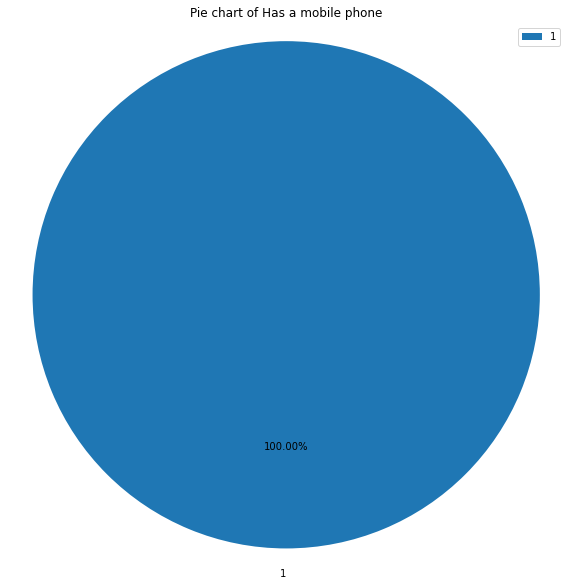

In [77]:
create_pie_plot(cc_train_copy,'Has a mobile phone')

Interpretation:
- All the applicants without exception have a mobile phone

## 16. Has a phone

In [78]:
# Note: Here 0 is no and 1 is yes

In [79]:
gen_info_feat(cc_train_copy,'Has a phone')

Description:
count   29165.00
mean        0.29
std         0.46
min         0.00
25%         0.00
50%         0.00
75%         1.00
max         1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  20562          70.50
1   8603          29.50


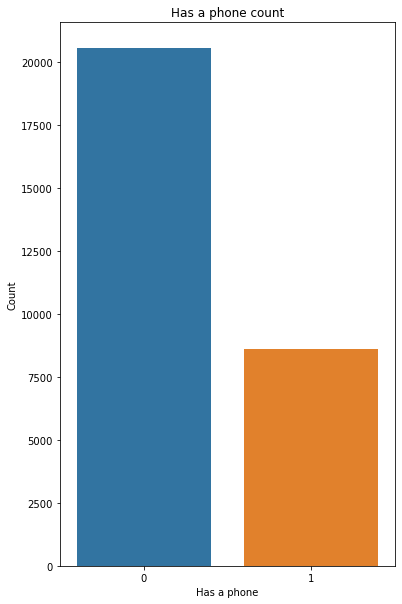

In [80]:
create_bar_plot(cc_train_copy,'Has a phone')

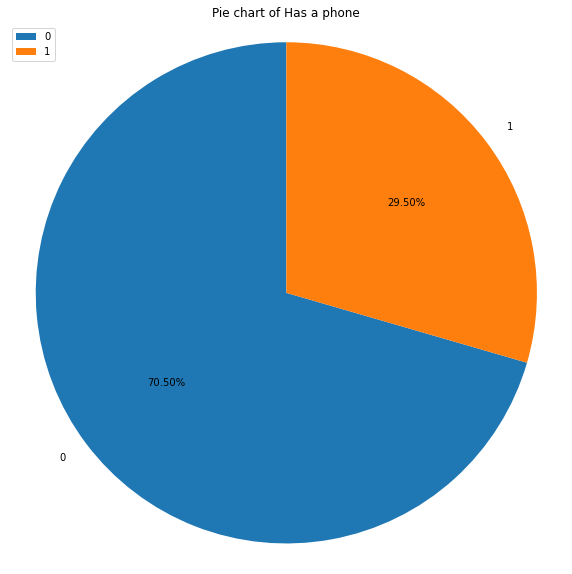

In [81]:
create_pie_plot(cc_train_copy,'Has a phone')

Interpretation:
- Most applicants don’t have a phone (probably a home phone)

## 17. Has an email

In [82]:
# Note: Here 0 is no and 1 is yes

In [83]:
gen_info_feat(cc_train_copy,'Has an email')

Description:
count   29165.00
mean        0.09
std         0.29
min         0.00
25%         0.00
50%         0.00
75%         0.00
max         1.00
Name: Has an email, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0  26532          90.97
1   2633           9.03


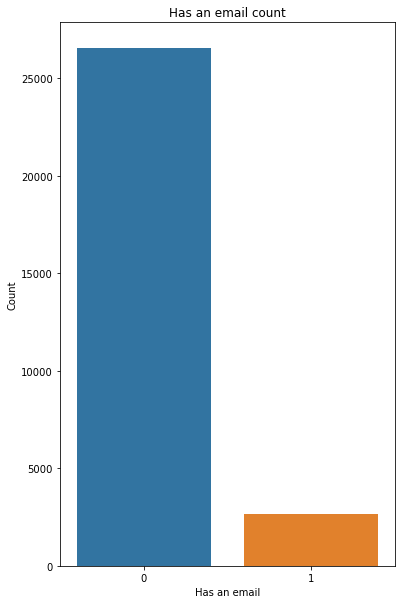

In [84]:
create_bar_plot(cc_train_copy,'Has an email')

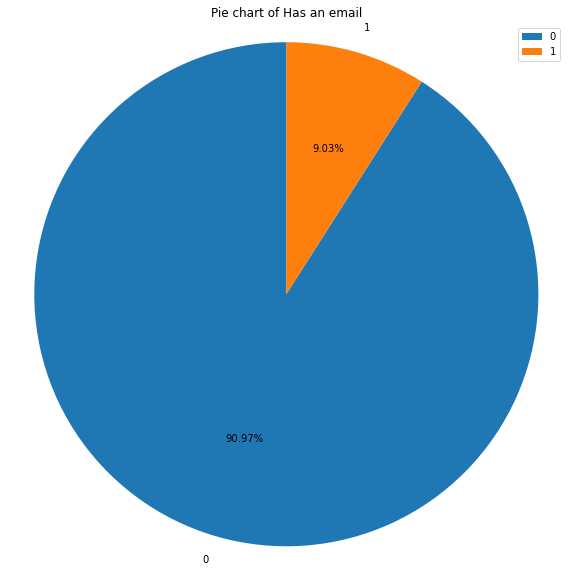

In [85]:
create_pie_plot(cc_train_copy,'Has an email')

Interpretation:
- More than 90% of applicants don’t have an email

## 18. Account age in months

In [100]:
gen_info_feat(cc_train_copy,'Account age in months')

Description:
count   29165.00
mean       26.14
std        16.49
min         0.00
25%        12.00
50%        24.00
75%        39.00
max        60.00
Name: Account age in months, dtype: float64
**************************************************
Object type:int32


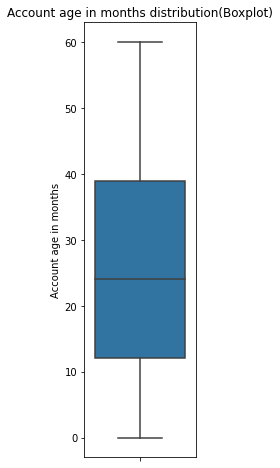

In [87]:
create_box_plot(cc_train_copy,'Account age in months')

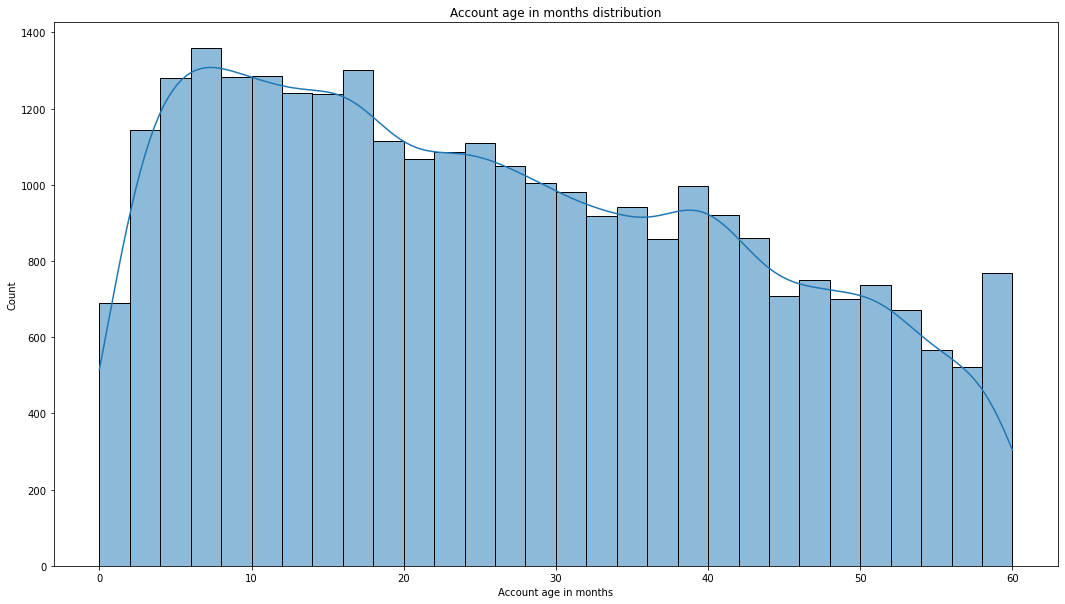

In [88]:
create_hist_plot(cc_train_copy,'Account age in months', the_bins=30)

Is high risk
0   26.00
1   34.04
Name: Account age in months, dtype: float64


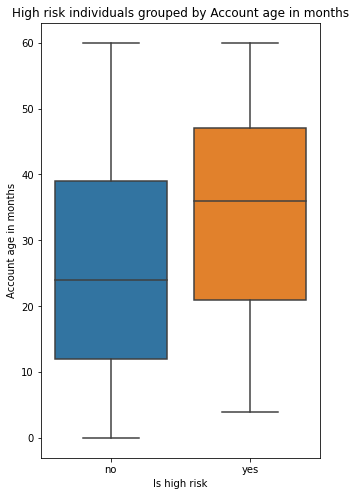

In [89]:
low_high_risk_box_plot(cc_train_copy,'Account age in months')

Interpretation:
-	Most accounts are 26 months old
-	Account age is not normally distributed, it is positively skewed
-	The accounts that have been flagged as high risk are on average 34 months old vs 26 months old for old account

## 19. Is high risk (target variable)

In [91]:
gen_info_feat(cc_train_copy,'Is high risk')

Description:
count     29165
unique        2
top           0
freq      28666
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
0  28666          98.29
1    499           1.71


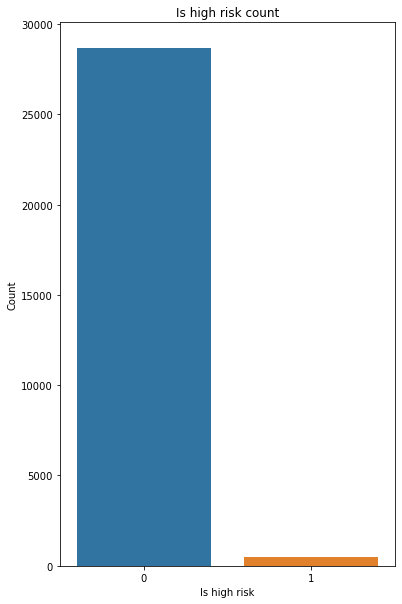

In [92]:
create_bar_plot(cc_train_copy,'Is high risk')

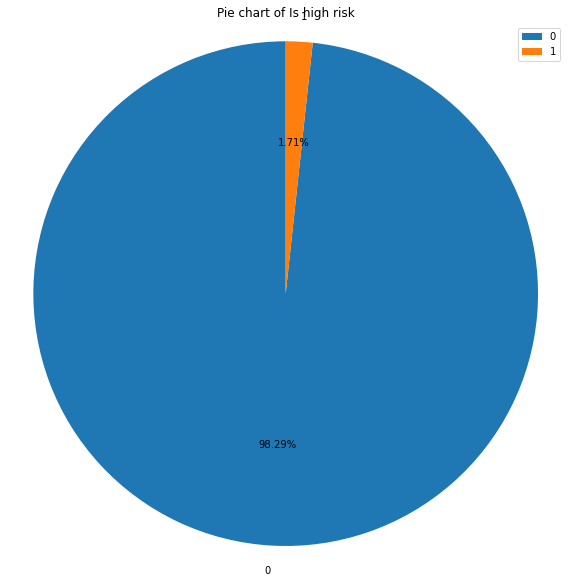

In [93]:
create_pie_plot(cc_train_copy,'Is high risk')

Interpretation:
- A vast majority of applicants are low risk applicants.
- We have a very imbalance data.


## Pairplot

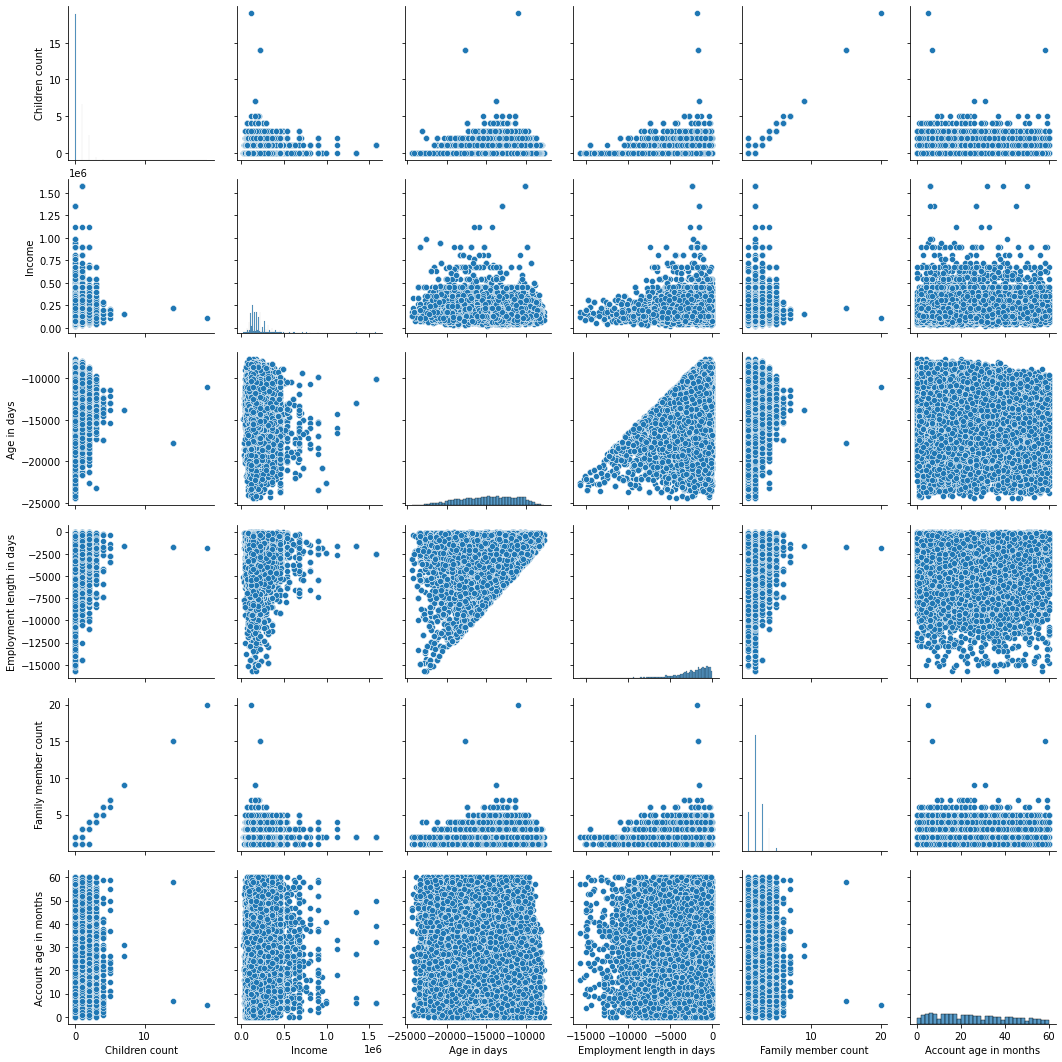

In [110]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length in days'] < 0].drop(['ID','Has a mobile phone', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1))
plt.show()

## Correlation analysis

## Key findings from the EDA

- In the training set, we have 29165 observation and 20 features including the target
- categorical features: Gender, Has a car, Has a property, Employment type, Education level, Marital status, Dwelling, Job title, Is high risk
- numerical features: ID, Children count, Income, Age in days, Employment length in days,Has a mobile phone, Has a work phone, Has a phone, Has an email.
- ***Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property(a house/ apartment). Her account is 26 months old.***

**********************************************************************************************************************************************************

In [95]:
cc_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29165 entries, 0 to 29164
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         29165 non-null  int64  
 1   Gender                     29165 non-null  object 
 2   Has a car                  29165 non-null  object 
 3   Has a property             29165 non-null  object 
 4   Children count             29165 non-null  int64  
 5   Income                     29165 non-null  float64
 6   Employment type            29165 non-null  object 
 7   Education level            29165 non-null  object 
 8   Marital status             29165 non-null  object 
 9   Dwelling                   29165 non-null  object 
 10  Age in days                29165 non-null  int64  
 11  Employment length in days  29165 non-null  int64  
 12  Has a mobile phone         29165 non-null  int64  
 13  Has a work phone           29165 non-null  int

- categorical features: Gender, Has a car, Has a property, Employment status, Education level, Marital status, Dwelling, Job title, Is high risk
- numerical features: ID, Children count, Income, Age in days, Employment length in days,Has a mobile phone, Has a work phone, Has a phone, Has an email.
- 

#### 4. For supervised learning tasks, identify the target attribute(s).

The target 'Is high risk'

#### Target analysis

In [ ]:
high_risk_count = application_train_copy['Is high risk'].value_counts()
high_risk_count 

In [ ]:
high_risk_ratio = application_train_copy['Is high risk'].value_counts(normalize=True) * 100
high_risk_ratio 

In [ ]:
plt.pie(high_risk_ratio,labels=['No','Yes'],autopct='%1.0f%%')
plt.title('High risk ratio')
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=high_risk_count.index,y=high_risk_count.values)
ax.set_xticklabels(['No','Yes'])
plt.xlabel('High risk')
plt.ylabel('Count')
plt.title('High risk count')
plt.show()

#### 5. Visualize the correlation within the data.

In [ ]:
sns.pairplot(application_train_copy[['Days since birth','Family size','Children count','Income','Days since employment (positive means unemployed)','Is high risk']],corner=True)
plt.show()

In [ ]:
app_corr_matrix = application_train_copy.corr()
app_corr_matrix

In [ ]:
mask = np.zeros_like(app_corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
app_corr_matrix[mask] = np.nan
(app_corr_matrix
 .style
 .background_gradient(cmap='bwr', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  
)

#### 6. Study the correlations between attributes.

#### 6.1 Family size vs Children count

In [ ]:
sns.regplot(x=application_train_copy['Family size'],y=application_train_copy['Children count'],line_kws={'color': 'red'})
plt.show()

#### Days since birth vs Days since employment

In [ ]:
sns.scatterplot(x=application_train_copy['Days since employment (positive means unemployed)'][application_train_copy['Days since employment (positive means unemployed)'] != 365243],y=application_train_copy['Days since birth'],alpha=.1)
plt.show()

#### 7. Study how you would solve the problem manually.

Consult expert subject matter in credit scoring

#### 8. Identify the promising transformations you may want to apply.

Transformation to do:

    - Encoding: Label encoding for sex
    - Encoding: Label encoding for Marital Status
    - Encoding: Label encoding for Way of living
    - Encoding: Label encoding for Occupation
    - Encoding: Label encoding for Has a car
    - Encoding: Label encoding for Has a property
    - Encoding: Label encoding for Income Category
    - Encoding: Label encoding for Education
    
    - Custom Transformation: Detect and remove outliers
    - Custom Transformation: Remove missing data
    - Custom Transformation: Balance the data in pipeline
    - Custom Transformation: Change to absolute value and divide the Days since birth by 365.25
    - Custom Transformation: Change name Days since birth to Age
    - Custom Transformation: Change to absolute value and divide the Days since employment by 365.25
    - Custom Transformation: Change name Days since employment to Experience length
    - Custom Transformation: Drop has mobile phone
    - Customer Transformation: Balance the skewed data income column, age, experience length
   
        ** Toggle and check with model perfomance
    - Custom Transformation: Keep Family size and drop Children count 
    - Custom Transformation: Keep Children count and drop Family size
    - Custom Transformation: Keep/drop the occupation column
    - Custom Transformation: Use Days of employment as part of the outliers column
    
    
    - Scalling: Min-max for Age
    - Scalling: Min-max for income
    - Scalling: Min-max for Experience   
    
    
    - Imputation: Impute Occupation
   
    - Oversample with SMOTE after encoding before modelling  

#### 9. Identify extra data that would be useful (go back to “Get the Data”).

Not applicable

#### 10. Document what you have learned.

Refer to the report

### Prepare the Data

#### 1. Data Cleaning

#### 1.1 Custom transformer to handle outliers

In [ ]:
class OutlierExtractor(BaseEstimator, TransformerMixin):
    def __init__(self,add_days_employed_to_col=False,outlier_col = ['Family size','Children count','Income']):
        self.outlier_col = outlier_col
        self.add_days_employed_to_col = add_days_employed_to_col
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        outlier_col = []
        def outlier_cal(outlier_col):
            Q1 = X[self.outlier_col].quantile(.25)
            Q3 = X[self.outlier_col].quantile(.75)
            IQR = Q3 - Q1
            outlier_condition = (X[self.outlier_col] < (Q1 - 1.5 * IQR)) | (X[self.outlier_col] > (Q3 + 1.5 * IQR))
            index_to_keep = X[~outlier_condition.any(axis=1)].index
            return X.loc[index_to_keep]
        if self.add_days_employed_to_col:
            self.outlier_col.append('Days since employment (positive means unemployed)')
            return outlier_cal(self.outlier_col)
        else:
            if len(self.outlier_col) == 3:
                return outlier_cal(self.outlier_col)
            else:
                self.outlier_col.remove('Days since employment (positive means unemployed)')
                return outlier_cal(self.outlier_col)

In [ ]:
outlier_remover = OutlierExtractor()

#### 1.2 Custom transformer to handle missing value

In [ ]:
application_train_copy[application_train_copy['Days since employment (positive means unemployed)'] == 365243]['Occupation']

In [ ]:
application_train['Occupation'].value_counts()

In [ ]:
class MissingValHandler(BaseEstimator, TransformerMixin):
    def __init__(self,drop_occupation=False):
        self.drop_occupation = drop_occupation
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_occupation:
            X_no_occ = X.drop('Occupation',axis=1)
            return X_no_occ
        else:
            nan_pensioner = X[X['Days since employment (positive means unemployed)'] == 365243]['Occupation']
            nan_pensioner_idx = X.loc[nan_pensioner.index.to_list()]['Occupation'].index.to_list()
            X.at[nan_pensioner_idx,'Occupation'] = 'Retired'
            #rest of nan other than the ones related to the retiment situation
            rest_nan_idx = X['Occupation'][X['Occupation'].isna()].index.to_list()
            most_freq_occ = X['Occupation'].value_counts().index[0]
            X['Occupation'].loc[rest_nan_idx] = most_freq_occ
            return X

#### 2. Feature selection

In [ ]:
application_train_copy = application_train.copy()

In [ ]:
class ColumnsToDrop(BaseEstimator,TransformerMixin):
    def __init__(self,column_to_drop = []):
        self.column_to_drop = column_to_drop
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.column_to_drop).issubset(X.columns)):
                self.column_to_drop.append('Has a mobile phone')
                X.drop(self.column_to_drop,axis=1,inplace=True)
                return X
        else:
            if (set('Has a mobile phone').issubset(X.columns)):
                X.drop('Has a mobile phone',axis=1,inplace=True)
                return X
            else:
                return X

In [ ]:
feat_selector = ColumnsToDrop()

#### 3. Feature engineering

#### 3.1 Days transformation

In [ ]:
class DaysTransformation(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.days_col = ['Days since birth','Days since employment (positive means unemployed)']
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if (set(self.days_col).issubset(X.columns)):
            for col in self.days_col:
                if col == 'Days since birth':
                    X['Age'] = np.abs(X[col])/365.25
                    X.drop(col,axis=1,inplace=True)
                elif col == 'Days since employment (positive means unemployed)':
                    X[col] = np.abs(X[col])/365.25
                    X[X[col] == 999.980][col] = -1
                    X['Employment lenght (in years)'] = X[col]
                    X.drop(col,axis=1,inplace=True)
            return X
        else:
            return X

In [ ]:
day_col_est = DaysTransformation()

#### 3.2 Family children column drop

In [ ]:
class FamilyChildrenColToggle(BaseEstimator,TransformerMixin):
    def __init__(self, drop_family_col = False, drop_child_col = False):
        self.drop_family_col = drop_family_col
        self.drop_child_col = drop_child_col
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.drop_family_col & ('Family size' in X.columns):
            X.drop('Family size',axis=1,inplace=True) 
            return X 
        elif self.drop_child_col & ('Children count' in X.columns):
            X.drop('Children count',axis=1,inplace=True) 
            return X
        else:
            return X        

#### 3.3 Oversampling with SMOTE

In [ ]:
class OversampleSMOTE(BaseEstimator,TransformerMixin):
    def __init__(self, perform_oversampling = True):
        self.perform_oversampling = perform_oversampling
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.perform_oversampling:
            smote = SMOTE()
            X_bal, y_bal = smote.fit_resample(X[:,:-1],X[:,-1])
            X_y_bal = np.concatenate((X_bal,y_bal[:,None]),axis=1)
            return X_y_bal

        else:
            return X

#### 3.4 Target transformation column 

In [ ]:
class TargetColTransformation(BaseEstimator,TransformerMixin):
    def __init__(self,target_pos_change = False,target_drop = False):
        self.target_pos_change = target_pos_change
        self.target_drop = target_drop
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        if self.target_drop:
            if self.target_pos_change == False:
                X_col_list = X.columns.to_list()
                X_col_list.remove('Is high risk')
                X = X[X_col_list]
                return X
            else:
                print('Cant change the position of the target while it was dropped')
                return X
        else:
            if self.target_pos_change:
                X_col_list = X.columns.to_list()
                X_col_list.remove('Is high risk')
                X_col_list.append('Is high risk')
                X = X[X_col_list]
                return X
            else:
                return X

#### 4. Feature scaling

Implemented with Column Transformer, but we will create a feature selector for selection the column to be scaled

#### 5. Put everything together in a column transformer/pipeline

In [ ]:
application_train_copy = application_train.copy()
application_test_copy = application_test.copy()

In [ ]:
def full_pipeline(df,type_dataframe):
    #columns to use in the column transformer
    enc_columns = ['Sex','Marital status','Way of living','Occupation','Has a car','Has a property','Income category','Education level']
    scale_columns = ['Age','Income','Employment lenght (in years)']

    #pipeline 
    if type_dataframe == 'Train':
        pipeline = Pipeline([
        ('imputer_missing',MissingValHandler()), #Has toggle option
         ('outlier',OutlierExtractor()), #Has toggle option
         ('feat_select',ColumnsToDrop()), #Has toggle option
         ('day_trans',DaysTransformation()),
         ('family_chil_trans',FamilyChildrenColToggle()), #Has toggle option
         ('y_trans',TargetColTransformation(target_pos_change = True))
        ])
        #Column transformer
        col_transformer = ColumnTransformer([
         ('encoder',OrdinalEncoder(),enc_columns),
         ('scaler',MinMaxScaler(),scale_columns),], remainder='passthrough')

    #     #pipeline for SMOTE
        pipeline_smote = Pipeline([
         ('smote',OversampleSMOTE())
         ])
    elif type_dataframe == 'Test':
        pipeline = Pipeline([
        ('imputer_missing',MissingValHandler()), #Has toggle option
        ('outlier',OutlierExtractor()), #Has toggle option
        ('feat_select',ColumnsToDrop()), #Has toggle option
        ('day_trans',DaysTransformation()),
        ('family_chil_trans',FamilyChildrenColToggle()), #Has toggle option
        # drop the target to avoid data snooping
        ('y_trans',TargetColTransformation(target_drop=True))
        ])
              #Column transformer
        col_transformer = ColumnTransformer([
        ('encoder',OrdinalEncoder(),enc_columns),
        ('scaler',MinMaxScaler(),scale_columns),], remainder='passthrough')

        #pipeline for SMOTE
        pipeline_smote = Pipeline([
        ('smote',OversampleSMOTE())
        ])

    
    
    if type_dataframe == 'Train':
        df_pip = pipeline.fit_transform(df)
        df_prepared = col_transformer.fit_transform(df_pip)
        df_bal = pipeline_smote.fit_transform(df_prepared)
        X_prep = df_bal[:,:-1]
        y_prep = df_bal[:,-1]
        return X_prep, y_prep
    # ToDo: Finish the test 
    elif type_dataframe == 'Test':
        df_pip = pipeline.transform(df)
        print(df_pip.columns)
        df_prepared = col_transformer.transform(df_pip)
        print(df_prepared.shape)
#         df_bal = pipeline_smote.transform(df_prepared)
#         print(df_bal.shape)
    else:
        print('Please select 'Train' or 'Test' for type_dataframe')

In [ ]:
X_train_prep, y_train_prep = full_pipeline(application_train_copy, 'Train')

In [ ]:
X_train_prep.shape

In [ ]:
y_train_prep.shape

### Shortlist Promising Models

In [ ]:
def fit_evaluate_model(model,X_train_prep,y_train_prep,cross_val = False):
    
    if cross_val:
        score_list = ['precision','recall','f1','accuracy','roc_auc']
        for score in score_list:
            scores = cross_val_score(model,X_train_prep,y_train_prep,scoring=score,cv=10)
            print('\n                        {} Score\n'.format(score))
            print('All the scores: {}'.format(scores))
            print('Mean of the scores: {}'.format(scores.mean()))
            print('Standard deviation: {}'.format(scores.std()))
            print('\n*****************************************************\n')
        
    else:
        model.fit(X_train_prep, y_train_prep)
        y_train_prediction = model.predict(X_train_prep)

        print('                        Classification Report')
        print(classification_report(y_train_prep,y_train_prediction))
        print('*****************************************************')

        print('Accuracy score {}'.format(accuracy_score(y_train_prep,y_train_prediction)))
        print('Confusion Matrix')
        plot_confusion_matrix(model,X_train_prep,y_train_prep)
        plt.show()
        print('*****************************************************')

        no_risk_probs = [0 for _ in range(len(y_train_prep))]
        risk_probs = model.predict_proba(X_train_prep)
        risk_probs_pos_outcome = risk_probs[:,1]
        no_risk_auc = roc_auc_score(y_train_prep,no_risk_probs)
        risk_auc = roc_auc_score(y_train_prep,risk_probs_pos_outcome)
        print('No risk: ROC AUC=%.3f' % (no_risk_auc))
        print('High risk: ROC AUC=%.3f' % (risk_auc))
        no_risk_false_pos_rate, no_risk_true_pos_rate, _ = roc_curve(y_train_prep,no_risk_probs)
        risk_false_pos_rate, risk_true_pos_rate, _ = roc_curve(y_train_prep,risk_probs_pos_outcome)
        plt.plot(no_risk_false_pos_rate, no_risk_true_pos_rate, linestyle='--', label='No risk')
        plt.plot(risk_false_pos_rate, risk_true_pos_rate, marker='.', label='High risk')
        # axis labels
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()

#### 1. Quick models comparison

#### 1.1 Logistic Regression

In [ ]:
log_reg = LogisticRegression(max_iter=1000)

In [ ]:
fit_evaluate_model(log_reg,X_train_prep,y_train_prep)
warnings.filterwarnings('ignore', category=DeprecationWarning) 

#### 1.2. Support Vector Machines

In [ ]:
svc_model = SVC(probability=True)

In [ ]:
fit_evaluate_model(svc_model,X_train_prep,y_train_prep)

#### Hyperparameter tuning SVM

In [ ]:
param_grid = {'C': [0.1,1, 10, 100,1000], 'gamma': [1,0.1,0.01,0.001,0.0001],'kernel': ['rbf', 'poly', 'sigmoid']}

In [ ]:
rand_search = RandomizedSearchCV(svc_model,param_grid, refit=True,cv=5,scoring='accuracy',n_jobs=-1,return_train_score=True,verbose=2)

In [ ]:
rand_search.fit(X_train_prep,y_train_prep)

In [ ]:
rand_search.best_estimator_

In [ ]:
rand_search.best_params_

#### 1.3. Decision Tree

In [ ]:
dt_clf = DecisionTreeClassifier()

In [ ]:
fit_evaluate_model(dt_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(dt_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### * Hyperparameters tuning

In [ ]:
param_grid = [
    {
    'max_depth':[2,3,4,6,8,10,12,15,20], 
    'min_samples_leaf':[1,2,4,6,8,10,20,30],
    'min_samples_split':[1,2,3,4,5,6,8,10]
    }
]

In [ ]:
grid_search = GridSearchCV(dt_clf,param_grid,cv=10,scoring='accuracy',n_jobs=-1,return_train_score=True)

#### * Cost-complexity pruning

In [ ]:
path = dt_clf.cost_complexity_pruning_path(X_train_prep, y_train_prep)
ccp_alphas = path.ccp_alphas
ccp_alphas

In [ ]:
acc_train = []
acc_test = []

for val in ccp_alphas:
  dt_clf = DecisionTreeClassifier(ccp_alpha=val, random_state=42)
  dt_clf.fit(X_train_prep, y_train_prep)
  y_train_pred = dt_clf.predict(X_train_prep) # Predictions
  y_true = y_test # True values
  acc_train.append(accuracy_score(y_train, dtclf.predict(X_train)))
  acc_test.append(accuracy_score(y_true, y_pred))

#### 1.4. Random Forests

In [ ]:
rf_clf = RandomForestClassifier()

In [ ]:
fit_evaluate_model(rf_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(rf_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.5. Gaussian Naive Bayes

In [ ]:
GaussianNB_clf = GaussianNB()

In [ ]:
fit_evaluate_model(GaussianNB_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(GaussianNB_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.6. KNN

In [ ]:
knn_clf = KNeighborsClassifier()

In [ ]:
fit_evaluate_model(knn_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(knn_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.7. Gradient Boosting

In [ ]:
gboost_clf = GradientBoostingClassifier()

In [ ]:
fit_evaluate_model(gboost_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(gboost_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.8. Linear Discriminant Analysis

In [ ]:
lda_clf = LinearDiscriminantAnalysis()

In [ ]:
fit_evaluate_model(lda_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(lda_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.9. Bagging

In [ ]:
bgg_clf = BaggingClassifier()

In [ ]:
fit_evaluate_model(bgg_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(bgg_clf,X_train_prep,y_train_prep,has_overfitted=True)

#### 1.10. Stochastic Gradient Descent Classifier (SGDC)

In [ ]:
sgdc_clf = SGDClassifier(loss='log')

In [ ]:
fit_evaluate_model(sgdc_clf,X_train_prep,y_train_prep)

#### * K-fold cross-validation 

In [ ]:
fit_evaluate_model(sgdc_clf,X_train_prep,y_train_prep,cross_val=True)

#### 1.11. Neural network (MLPClassifier)

In [ ]:
mlp_clf = MLPClassifier()

In [ ]:
fit_evaluate_model(mlp_clf,X_train_prep,y_train_prep)

#### * K-fold cross validation

In [ ]:
fit_evaluate_model(mlp_clf,X_train_prep,y_train_prep,has_overfitted=True)